In [1]:
%matplotlib inline

# Reflection on interfaces between two materials
Authors: O. Castany, C. Molinaro, M. Müller

This notebook analyzes the optical behavior at the interface between two isotropic materials with refractive indices n1 and n2.

It computes the reflection and transmission coefficients as functions of the incidence angle, for both s- and p-polarized light, 
using the analytical Fresnel equations and comparing those to pyElli's output.

## Import required libraries

In [2]:
import elli
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c, pi

## Structure definition

We define an optical system with two materials:

- Frontside medium (air) with refractive index n = 1.0 
- Back medium (glass) with n = 1.5

We also prepare the vacuum wavevector k0 and a range of incidence angles from 0° to 89°.

In [3]:
# Define refractive indices for the two media
n1 = 1
n2 = 1.5

# Create isotropic materials using pyElli's ConstantRefractiveIndex model
front = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n1))
back = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n2))

# Define the optical structure: just a single interface with no internal layers
s = elli.Structure(front, [], back)

# Set wavelength and wavevector
lbda = 1000
k0 = 2 * pi / lbda

# Define a range of incidence angles from 0° to 89°
Phi_list = np.linspace(0, 89, 90)

## Analytical calculation

We calculate the Fresnel reflection and transmission coefficients for s- and p-polarized light at an interface.

In [4]:
# Convert incidence angles from degrees to radians
Phi_i = np.deg2rad(Phi_list)

# Snell's law (allowing complex values for total internal reflection)
Phi_t = np.arcsin((n1 * np.sin(Phi_i) / n2).astype(complex))

kz1 = n1 * k0 * np.cos(Phi_i)
kz2 = n2 * k0 * np.cos(Phi_t)

# Fresnel coefficients
r_s = (kz1 - kz2) / (kz1 + kz2)
t_s = 1 + r_s
r_p = (kz1 * n2**2 - kz2 * n1**2) / (kz1 * n2**2 + kz2 * n1**2)
t_p = np.cos(Phi_i) * (1 - r_p) / np.cos(Phi_t)

# Reflectance and Transmittance
R_th_ss = abs(r_s) ** 2
R_th_pp = abs(r_p) ** 2
t2_th_ss = abs(t_s) ** 2
t2_th_pp = abs(t_p) ** 2

# The power transmission coefficient (correction for energy conservation) is T = Re(kz2/kz1) × |t|^2
correction = np.real(kz2 / kz1)
T_th_ss = correction * t2_th_ss
T_th_pp = correction * t2_th_pp

## Calculation with pyElli

Here, we simulate the same interface using pyElli.

Each angle is evaluated using `Structure.evaluate()` and then grouped in a `ResultList` object to get angle dependent arrays.

In [5]:
data = elli.ResultList([s.evaluate(lbda, Phi_i) for Phi_i in Phi_list])

R_pp = data.R_pp
R_ss = data.R_ss

T_pp = data.T_pp
T_ss = data.T_ss

t2_pp = np.abs(data.t_pp) ** 2
t2_ss = np.abs(data.t_ss) ** 2

## Comparing results

- Theoretical results as dotted lines
- PyElli results as solid lines

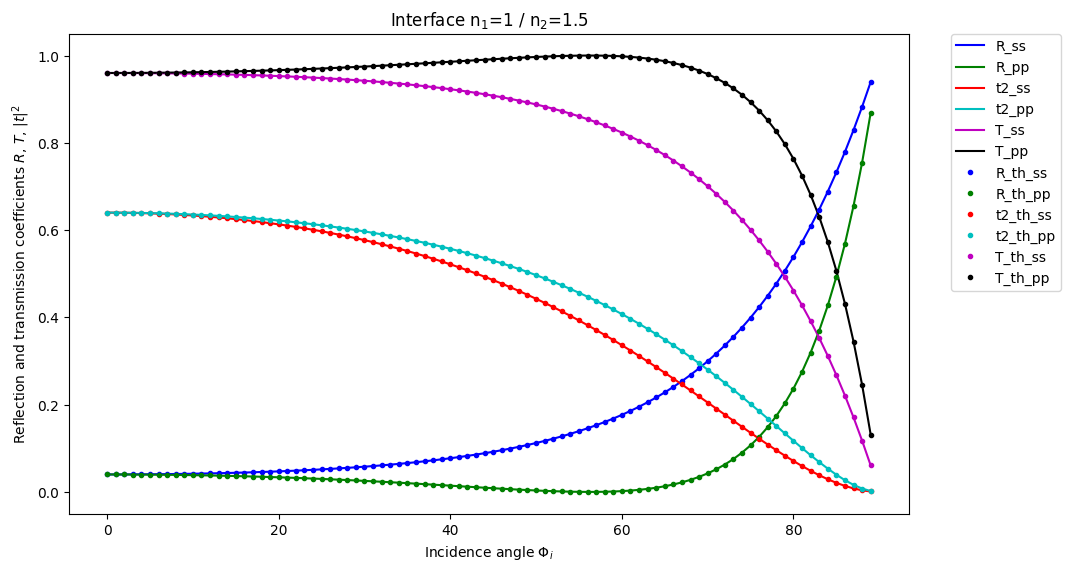

In [6]:
fig = plt.figure(figsize=(12.0, 6.0))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", "bgrcmk")
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])

d = np.vstack((R_ss, R_pp, t2_ss, t2_pp, T_ss, T_pp)).T
lines1 = ax.plot(Phi_list, d)
legend1 = ("R_ss", "R_pp", "t2_ss", "t2_pp", "T_ss", "T_pp")

d = np.vstack((R_th_ss, R_th_pp, t2_th_ss, t2_th_pp, T_th_ss, T_th_pp)).T
lines2 = ax.plot(Phi_list, d, ".")
legend2 = ("R_th_ss", "R_th_pp", "t2_th_ss", "t2_th_pp", "T_th_ss", "T_th_pp")

ax.legend(
    lines1 + lines2,
    legend1 + legend2,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

ax.set_title("Interface n$_1$={:} / n$_2$={:}".format(n1, n2))
ax.set_xlabel(r"Incidence angle $\Phi_i$ ")
ax.set_ylabel(r"Reflection and transmission coefficients $R$, $T$, $|t|^2$")

plt.show()